In [ ]:
%%javascript
IPython.notebook.clear_all_output();

In [1]:
import os 
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from glob import glob
import matplotlib.image as image
import time
# import splitfolders 

from tensorflow.keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf
import tensorflow.keras.backend as Backend

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Lambda


In [2]:
dir_name = "./data_2500"

files='**/*.jpg'
filenames = glob(os.path.join(dir_name, files))
classes = [os.path.basename(os.path.dirname(name)) for name in filenames]
count = list(Counter(classes).items())
print("Class count:", count);

Class count: [('Slippers', 2500), ('Sandals', 2500), ('Boots', 2500), ('Shoes', 2500)]


In [3]:
class_names = os.listdir(dir_name) # Get names of classes
class_name2id = { label: index for index, label in enumerate(class_names) } # Map class names to integer labels
print("Classes:", class_name2id)

labels = [class_name2id[c] for c in classes]
Counter(labels)

Classes: {'Slippers': 0, 'Sandals': 1, 'Boots': 2, 'Shoes': 3}


Counter({0: 2500, 1: 2500, 2: 2500, 3: 2500})

In [4]:
# config
IMG_SHAPE = (102, 102, 3)
IMG_SIZE = (102, 102) 
BATCH_SIZE = 16
# EPOCHS = 32
EPOCHS = 20

In [5]:
def get_image(filename):
    img_obj = load_img(filename, target_size=IMG_SIZE) # image object
    numpy_image = img_to_array(img_obj) # image object -> pixel array
    return numpy_image

def map_dataset(filenames):
    data = []
    for i in range(len(filenames)):
        data.append(get_image(filenames[i]))
#         if(i % 1000 == 0): print(i, 'images loaded')
    return np.array(data)/255.0

def get_files_labels(path):
    files = glob(os.path.join(path, '**/*.jpg'))
    classes = [os.path.basename(os.path.dirname(name)) for name in files]
    labels = [class_name2id[c] for c in classes]
    return files, np.array(labels)
    

In [6]:
train_path = "splitted_data/train"
train_files, train_y = get_files_labels(train_path)
print("Train:", Counter(train_y))

test_path = "splitted_data/test"
test_files, test_y = get_files_labels(test_path)
print("Test:", Counter(test_y))

val_path = "splitted_data/val"
val_files, val_y = get_files_labels(val_path)
print("Validation:", Counter(val_y))


Train: Counter({0: 2000, 1: 2000, 2: 2000, 3: 2000})
Test: Counter({0: 250, 1: 250, 2: 250, 3: 250})
Validation: Counter({0: 250, 1: 250, 2: 250, 3: 250})


In [7]:
%%time
train_X = map_dataset(train_files)
test_X = map_dataset(test_files)
val_X = map_dataset(val_files)

CPU times: user 5.71 s, sys: 1.84 s, total: 7.55 s
Wall time: 1min 46s


In [8]:
print(train_X.shape)
print(train_y.shape)
# print(train_X[0])

(8000, 102, 102, 3)
(8000,)


# Make Pairs for Siamese Network

In [9]:
def make_pos_neg_pairs(X, y):
    pairs = [] # (image, image) pair 
    labels = [] # 0 means negative pair, otherwise, positive
    
    class_count = len(np.unique(y))
    class_indexes = [np.where(y == i)[0] for i in range(0, class_count)]
    
    for i in range(len(X)):
        cur_img = X[i]
        cur_label = y[i]
#         print(cur_label)
        
        # positive: pick an image from same class randomly
        pos_i = np.random.choice(class_indexes[cur_label]) 
        pos_img = X[pos_i]
        pairs.append([cur_img, pos_img])
        labels.append([1])
        
        # negative: pick an image from other classes randomly
        neg_ids = np.where(y != cur_label)[0]
        neg_img = X[np.random.choice(neg_ids)]        
        pairs.append([cur_img, neg_img])
        labels.append([0])
        
    return (np.array(pairs), np.array(labels))

In [10]:
%%time

(train_paris, train_labels) = make_pos_neg_pairs(train_X, train_y)
(val_paris, val_labels) = make_pos_neg_pairs(val_X, val_y)

CPU times: user 843 ms, sys: 943 ms, total: 1.79 s
Wall time: 1.79 s


In [11]:
np.unique(train_labels, return_counts=True)

(array([0, 1]), array([8000, 8000]))

In [12]:
print(train_paris.shape)
print(train_labels.shape)
print(val_paris.shape)
print(val_labels.shape)

(16000, 2, 102, 102, 3)
(16000, 1)
(2000, 2, 102, 102, 3)
(2000, 1)


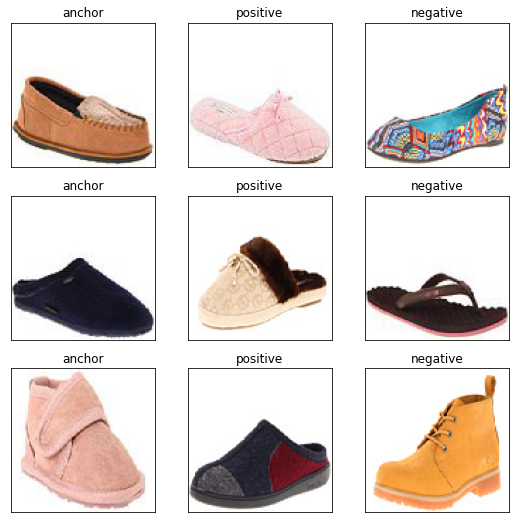

In [13]:
def show(ax, image, title):
    ax.imshow(image)
    ax.set_title(title)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
fig = plt.figure(figsize=(9, 9))
axs = fig.subplots(3, 3)
for i in range(3):
    show(axs[i, 0], train_paris[2*i][0], "anchor")
    show(axs[i, 1], train_paris[2*i][1], "positive")
    show(axs[i, 2], train_paris[2*i+1][1], "negative")

# Build Siamese Network

In [14]:
def siamese_model(shape, embedding_d=512): 
    inputs = Input(shape)
    x = Conv2D(64, (2, 2), padding="same", activation="relu")(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.5)(x)
    
    x = Conv2D(64, (2, 2), padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.5)(x)
    
#     x = GlobalAveragePooling2D()(x)
    x = Flatten()(x) # instade of GlobalAveragePooling2D
    
    x = Dense(2048, activation="relu")(x)

    outputs = Dense(embedding_d)(x)
    
    model = Model(inputs, outputs)
    
    return model

In [15]:
def cal_euclidean_distance(vector_tuple):
    (vector_1, vector_2) = vector_tuple
    sqr_sum = Backend.sum(Backend.square(vector_1 - vector_2), axis=1, keepdims=True)
    distance = Backend.sqrt(Backend.maximum(sqr_sum, Backend.epsilon()))
    return distance   

In [16]:
input_1 = Input(shape=IMG_SHAPE)
input_2 = Input(shape=IMG_SHAPE)
ext_features = siamese_model(IMG_SHAPE)
features_1 = ext_features(input_1)
features_2 = ext_features(input_2)
euc_distance = Lambda(cal_euclidean_distance)([features_1, features_2])
sia_model = Model(inputs=[input_1, input_2], outputs=euc_distance)
sia_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 102, 102, 3) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 102, 102, 3) 0                                            
__________________________________________________________________________________________________
model (Model)                   (None, 512)          82988416    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           model[1][0]                

In [17]:
ext_features.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 102, 102, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 102, 102, 64)      832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 51, 51, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 51, 51, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 51, 51, 64)        16448     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 25, 25, 64)        0     

# Trianing Model 

In [18]:
import time

In [19]:
def cal_loss(y, pred, margin=1):
    y = tf.cast(y, pred.dtype)
    square = Backend.square(pred)
    margin_square = Backend.square(Backend.maximum(margin - pred, 0))
    loss = Backend.mean(y * square + (1 - y) * margin_square)
    return loss

In [20]:
sia_model.compile(loss=cal_loss, optimizer="adam")

start_time = time.time()

history = sia_model.fit(
    [train_paris[:, 0], train_paris[:, 1]], train_labels[:],
    validation_data=([val_paris[:, 0], val_paris[:, 1]], val_labels[:]),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS)

print(f"\nTrained for {(time.time() - start_time) / 60} minutes ")

Epoch 1/20
1000/1000 [==============================] - 24s 24ms/step - loss: 0.4502 - val_loss: 0.4508
Epoch 2/20
1000/1000 [==============================] - 24s 24ms/step - loss: 0.1884 - val_loss: 0.2066
Epoch 3/20
1000/1000 [==============================] - 24s 24ms/step - loss: 0.1696 - val_loss: 0.1797
Epoch 4/20
1000/1000 [==============================] - 24s 24ms/step - loss: 0.1545 - val_loss: 0.1473
Epoch 5/20
1000/1000 [==============================] - 24s 24ms/step - loss: 0.1389 - val_loss: 0.1432
Epoch 6/20
1000/1000 [==============================] - 24s 24ms/step - loss: 0.1266 - val_loss: 0.1328
Epoch 7/20
1000/1000 [==============================] - 24s 24ms/step - loss: 0.1164 - val_loss: 0.1195
Epoch 8/20
1000/1000 [==============================] - 24s 24ms/step - loss: 0.1075 - val_loss: 0.1522
Epoch 9/20
1000/1000 [==============================] - 24s 24ms/step - loss: 0.0992 - val_loss: 0.1229
Epoch 10/20
1000/1000 [==============================] - 24s 24m

In [21]:
# print(history.history["loss"])

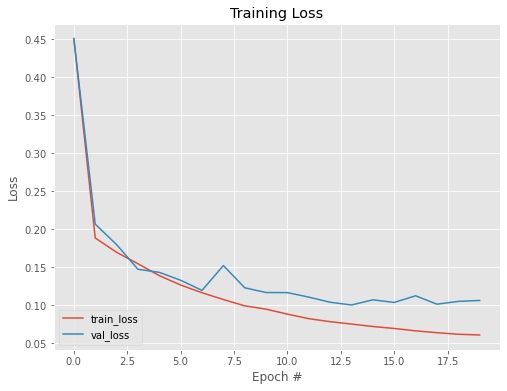

In [21]:
plt.style.use("ggplot")
plt.figure(figsize=(8, 6))
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")

In [ ]:
# (test_paris, test_labels) = make_pos_neg_pairs(test_X, test_y)

In [ ]:
# for i in range(5):
#     imageA = np.expand_dims(test_paris[i][0], axis=0)
#     imageB = np.expand_dims(test_paris[i][1], axis=0)
#     preds = sia_model.predict([imageA, imageB])
#     proba = preds[0][0]
    
#     fig = plt.figure("Pair #{}".format(i + 1), figsize=(4, 4))
#     plt.suptitle("Distance: {:.2f}".format(proba))
    
#     ax = fig.add_subplot(1, 2, 1)
#     plt.imshow(test_paris[i][0])
#     plt.axis("off")
    
#     ax = fig.add_subplot(1, 2, 2)
#     plt.imshow(test_paris[i][1])
#     plt.axis("off")
    
#     plt.show()
    

In [27]:
# ext_features.save('ext_features.h5')

# Single layer classifier

In [2]:
# ext_features = tf.keras.models.load_model("ext_features.h5")

In [13]:
# val_fetures

<tf.Tensor: shape=(1000, 512), dtype=float32, numpy=
array([[ 1.34427473e-01,  2.20434554e-03, -1.40369730e-02, ...,
        -1.20335305e-03,  3.23036290e-03,  5.14884887e-04],
       [ 1.77823886e-01,  1.91920344e-03, -1.66812371e-02, ...,
        -1.63444516e-03,  3.25123873e-03,  1.10324036e-04],
       [ 2.34770596e-01, -1.87915241e-04, -1.47440257e-02, ...,
        -6.16802194e-04,  3.92074464e-03, -1.00012112e-03],
       ...,
       [ 4.39204983e-02,  4.07120970e-04, -6.89767376e-02, ...,
        -6.50919159e-04, -7.65298679e-03, -7.41566764e-04],
       [ 2.69592032e-02,  1.64597784e-03, -5.30936643e-02, ...,
         5.79466578e-04, -5.56497043e-03, -5.19481488e-04],
       [ 7.54543394e-02,  1.03517738e-03, -3.63954082e-02, ...,
        -5.49638280e-05, -3.07879760e-03, -7.20118755e-04]], dtype=float32)>

In [22]:
# train_fetures = ext_features(train_X)
val_fetures = ext_features(val_X)
test_fetures = ext_features(test_X)

train_fetures = ext_features(train_X[:2000])
train_fetures2 = ext_features(train_X[2000:4000])
train_fetures3 = ext_features(train_X[4000:6000])
train_fetures4 = ext_features(train_X[6000:])

# val_fetures1 = ext_features(val_X[:500])
# val_fetures2 = ext_features(val_X[500:])
# test_fetures1 = ext_features(test_X[:500])
# test_fetures2 = ext_features(test_X[500:])

In [21]:
# train_fetures = ext_features(train_X[:500])
# train_fetures2 = ext_features(train_X[500:1000])
# train_fetures3 = ext_features(train_X[1000:1500])
# train_fetures4 = ext_features(train_X[1500:2000])
# train_fetures5 = ext_features(train_X[2000:2500])
# train_fetures6 = ext_features(train_X[2500:3000])
# train_fetures7 = ext_features(train_X[3000:3500])
# train_fetures8 = ext_features(train_X[3500:4000])
# train_fetures9 = ext_features(train_X[4000:4500])
# # train_fetures10 = ext_features(train_X[4000:4500])
# train_fetures11 = ext_features(train_X[4500:5000])
# train_fetures12 = ext_features(train_X[5000:5500])
# train_fetures13 = ext_features(train_X[5500:6000])
# train_fetures14 = ext_features(train_X[6000:6500])
# train_fetures15 = ext_features(train_X[6500:7000])
# train_fetures16 = ext_features(train_X[7000:7500])
# train_fetures17 = ext_features(train_X[7500:8000])

# train_fetures0 = np.concatenate((train_fetures,train_fetures2,train_fetures3, train_fetures4, train_fetures5, 
#                                  train_fetures6, train_fetures7, train_fetures8, train_fetures9,
#                                 train_fetures11, train_fetures12, train_fetures13, train_fetures14, train_fetures15,
#                                 train_fetures16, train_fetures17))

In [23]:
train_fetures0 = np.concatenate((train_fetures,train_fetures2,train_fetures3, train_fetures4))

In [24]:
train_fetures0.shape, train_X.shape, train_y.shape

((8000, 512), (8000, 102, 102, 3), (8000,))

In [35]:
# class_model = tf.keras.Sequential(name="class_model")
# class_model.add(tf.keras.layers.Dense(128, activation='relu', name="dense_layer1"))
# class_model.add(tf.keras.layers.BatchNormalization())
# class_model.add(tf.keras.layers.Dropout(0.5))
# class_model.add(tf.keras.layers.Dense(4, activation='softmax', name="predictions"))
# # class_model.add(layers.Dense(4, name="layer3"))

In [25]:
class_model = tf.keras.Sequential(name="class_model")
# class_model.add(tf.keras.layers.Dense(128, activation='relu', name="dense_layer1"))
# class_model.add(tf.keras.layers.BatchNormalization())
# class_model.add(tf.keras.layers.Dropout(0.5))
class_model.add(tf.keras.layers.Dense(4, activation='softmax', name="predictions"))
# class_model.add(layers.Dense(4, name="layer3"))

In [26]:
from tensorflow.keras.optimizers import SGD, Adam
import time

# SGD(lr=0.001, momentum=0.9)
# SGD(lr=0.00001, momentum=0.99)
class_model.compile(optimizer=Adam(lr=0.001), 
                    loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
                    metrics=["accuracy"]
                    )

start_time = time.time()

hist = class_model.fit(x=train_fetures0, y= train_y, 
                          epochs=30, 
                          validation_data=(val_fetures, val_y),
)

print(f"\nTrained for {(time.time() - start_time) / 60} minutes ")

Epoch 1/30
250/250 [==============================] - 0s 2ms/step - loss: 1.1082 - accuracy: 0.8944 - val_loss: 0.9266 - val_accuracy: 0.8820
Epoch 2/30
250/250 [==============================] - 1s 2ms/step - loss: 0.7179 - accuracy: 0.9479 - val_loss: 0.6770 - val_accuracy: 0.8920
Epoch 3/30
250/250 [==============================] - 0s 2ms/step - loss: 0.5045 - accuracy: 0.9515 - val_loss: 0.5386 - val_accuracy: 0.8950
Epoch 4/30
250/250 [==============================] - 0s 2ms/step - loss: 0.3818 - accuracy: 0.9536 - val_loss: 0.4568 - val_accuracy: 0.8950
Epoch 5/30
250/250 [==============================] - 0s 2ms/step - loss: 0.3067 - accuracy: 0.9545 - val_loss: 0.4059 - val_accuracy: 0.8950
Epoch 6/30
250/250 [==============================] - 0s 2ms/step - loss: 0.2581 - accuracy: 0.9567 - val_loss: 0.3725 - val_accuracy: 0.8950
Epoch 7/30
250/250 [==============================] - 0s 2ms/step - loss: 0.2248 - accuracy: 0.9578 - val_loss: 0.3498 - val_accuracy: 0.8960
Epoch 

In [27]:
from sklearn.metrics import classification_report

y_pred = class_model.predict(test_fetures)

# calculate classification accuracy
report = classification_report(test_y, np.argmax(y_pred, axis=1), target_names=class_names, digits=4)
print(report)


              precision    recall  f1-score   support

    Slippers     0.8264    0.8000    0.8130       250
     Sandals     0.8983    0.8480    0.8724       250
       Boots     0.9305    0.9640    0.9470       250
       Shoes     0.8365    0.8800    0.8577       250

    accuracy                         0.8730      1000
   macro avg     0.8729    0.8730    0.8725      1000
weighted avg     0.8729    0.8730    0.8725      1000



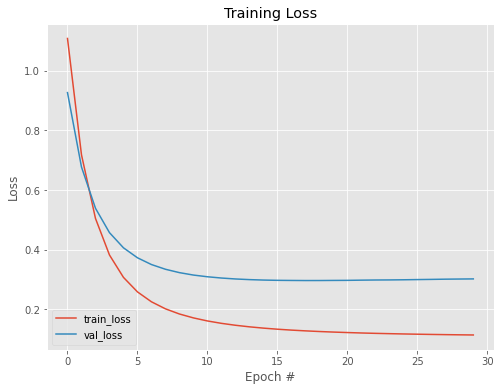

In [28]:
plt.style.use("ggplot")
plt.figure(figsize=(8, 6))
plt.plot(hist.history["loss"], label="train_loss")
plt.plot(hist.history["val_loss"], label="val_loss")
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")

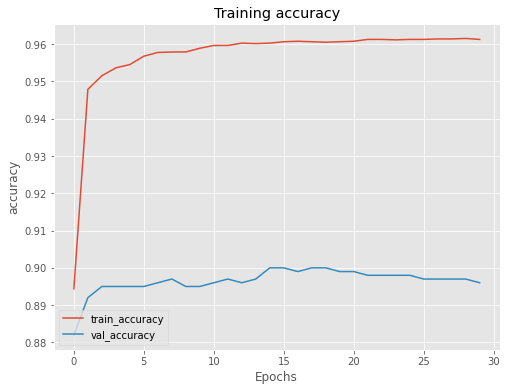

In [29]:
plt.style.use("ggplot")
plt.figure(figsize=(8, 6))
plt.plot(hist.history["accuracy"], label="train_accuracy")
plt.plot(hist.history["val_accuracy"], label="val_accuracy")
plt.title("Training accuracy")
plt.xlabel("Epochs")
plt.ylabel("accuracy")
plt.legend(loc="lower left")

# References
- https://www.pyimagesearch.com/2021/01/18/contrastive-loss-for-siamese-networks-with-keras-and-tensorflow/